In [1]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from coffea import util
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import pandas as pd

In [12]:
output = util.load('TTbarResCoffea_full_output.coffea') #Optionally pick from previous outputs
output

{'ttbarmass': <Hist (dataset,anacat,ttbarmass) instance at 0x7f262ab71290>,
 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7f26279abfd0>,
 'jetpt': <Hist (dataset,anacat,jetpt) instance at 0x7f262cca62d0>,
 'jeteta': <Hist (dataset,anacat,jeteta) instance at 0x7f2625df8690>,
 'jetphi': <Hist (dataset,anacat,jetphi) instance at 0x7f2629d59a50>,
 'subjetmass': <Hist (dataset,anacat,subjetmass) instance at 0x7f262e231610>,
 'subjetpt': <Hist (dataset,anacat,subjetpt) instance at 0x7f262e231a90>,
 'subjeteta': <Hist (dataset,anacat,subjeteta) instance at 0x7f26270d1290>,
 'subjetphi': <Hist (dataset,anacat,subjetphi) instance at 0x7f262d6d2590>,
 'numerator': <Hist (dataset,anacat,jetp) instance at 0x7f262d6d2450>,
 'denominator': <Hist (dataset,anacat,jetp) instance at 0x7f262d8bb390>,
 'cutflow': defaultdict_accumulator(int,
                         {'all events': 571071756,
                          'all JetHT events': 410461585,
                          'number of JetHT sets

In [3]:
Total_nevts = output['cutflow']['all events']
TTbar_nevts = output['cutflow']['all ttbar events'] 
QCD_nevts = output['cutflow']['all qcd events']
nevts = output['cutflow']['all JetHT events']
QCD_nchunks = output['cutflow']['number of qcd sets']
TTbar_nchunks = output['cutflow']['number of ttbar sets']
Data_nchunks = output['cutflow']['number of JetHT sets']
TTbar_sumw = output['cutflow']['ttbar sumw']
QCD_sumw = output['cutflow']['qcd sumw']
TTbar_sumw2 = output['cutflow']['ttbar sumw2']
QCD_sumw2 = output['cutflow']['qcd sumw2']

# ---- MC events ---- #
print('TTbar events = ', TTbar_nevts)
print('QCD events =   ', QCD_nevts)

# ---- Data events ---- #
print('Data events =  ', nevts)
print()

# ---- Compare events (Not Necessary...) ---- #
print('Total events =                     ', Total_nevts)
print('Monte Carlo = Total events?        ', TTbar_nevts+QCD_nevts == Total_nevts)
print('Monte Carlo + Data = Total events? ', TTbar_nevts+QCD_nevts+nevts == Total_nevts)
print()

# ---- Sum w and w2 info ---- #
print('TTbar sumw =   ', TTbar_sumw)
print('QCD sumw =     ', QCD_sumw)
print('TTbar sumw2 =  ', TTbar_sumw2)
print('QCD sumw2 =    ', QCD_sumw2)
print()

print('Number of QCD dataset chunks Processed =   ', QCD_nchunks)
print('Number of TTbar dataset chunks Processed = ', TTbar_nchunks)
print('Number of JetHT dataset chunks Processed = ', Data_nchunks)

TTbar events =  142155064
QCD events =    18455107
Data events =   410461585

Total events =                      571071756
Monte Carlo = Total events?         False
Monte Carlo + Data = Total events?  True

TTbar sumw =    1156050.75
QCD sumw =      0.012513789119111607
TTbar sumw2 =   23099143676.0
QCD sumw2 =     2.8781394920346717e-09

Number of QCD dataset chunks Processed =    188
Number of TTbar dataset chunks Processed =  1430
Number of JetHT dataset chunks Processed =  4109


In [4]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [5]:
def DoesDirectoryExist(mypath): #extra precaution (Probably overkill...)
    '''Checks to see if Directory exists before running mkdir_p'''
    import os.path
    from os import path
    
    if path.exists(mypath):
        pass
    else:
        mkdir_p(mypath)

In [6]:
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
warnings.filterwarnings("ignore")

# ---- Reiterate categories ---- #
ttagcats = ["at", "0t", "1t", "2t"]
btagcats = ["0b", "1b", "2b"]
ycats = ['cen', 'fwd']

list_of_cats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]

# ---- List the Histograms Here ---- #
list_of_hists = ('ttbarmass', 'jetpt', 'jeteta', 'jetphi')
                 #'numerator', 'denominator')

In [7]:
maindirectory = '/uscms_data/d1/acwillia/singularity/TTbarAllHadUprootFork/TTbarAllHadUproot' # change accordingly

In [8]:
""" ---------------- Luminosity Scaling ---------------- """
Lum = 41530. # pb^-1 from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable

TTbar_BR = 0.457 # 0.442 from PDG 2018
ttbar_xs = 831.76 * TTbar_BR  #pb
qcd_xs = 1370000000.0 #pb From https://cms-gen-dev.cern.ch/xsdb

#---- Integrated Luminosity ----#
Data_frac = nevts/62988012. # from dasgoclient -query="summary dataset=/JetHT/Run2017B-Nano25Oct2019-v1/NANOAOD"
Lum_frac = Lum*Data_frac
Lum_data = nevts/(ttbar_xs+qcd_xs)

# ---- Using SumW to get the Number of Weighted MC Events ---- #
TTbar_nevts_wgt = TTbar_nevts*TTbar_sumw # Approximate Number of Entries in the Histograms
QCD_nevts_wgt   = QCD_nevts*QCD_sumw 

# ---- Scale Factors to Normalize Total MC Events to Number of Data Events ---- #
# ---- N = L x sigma ---- #
# ---- (N_tt_wgt)(SF_tt) + (N_qcd_wgt)(SF_qcd) = Const.(N_data) ---- #
Const = (TTbar_sumw*ttbar_xs + QCD_sumw*qcd_xs)/(ttbar_xs+qcd_xs) # Found Algebraically
TTbar_sf = Lum_data * ttbar_xs / (Const*TTbar_nevts)
QCD_sf = Lum_data * qcd_xs / (Const*QCD_nevts)

# ---- Define Ratio to Normalize Weighted MC events to Data in Histograms ---- #
TotalMC_evts = (TTbar_nevts_wgt + QCD_nevts_wgt)
Ratio = nevts/TotalMC_evts # Apply universally to weighted MC histograms to Normalize to JetHT histograms 
Lum_MC = Lum_data/Ratio # 'Luminosity of Total MC' to achieve normalization to JetHT histograms after weighting with scale factors

# ---- Verify that Scale Factors are Normalizing MC to Data ---- #
TotalMC_evts_new = (TTbar_nevts_wgt*TTbar_sf + QCD_nevts_wgt*QCD_sf)
Ratio_new = nevts/TotalMC_evts_new # Should be equal to 1.

# ---- Histogram Scale Factors ---- #
# ---- Without Division of 'Ratio', MC Histograms appear to not be Normalized ---- #
scales = {'TTbar': TTbar_sf/Ratio, # Histogram Scale Factor = Lum_MC * cross_section / (Const * MC_events)
          'QCD': QCD_sf/Ratio}

Norm = (TTbar_nevts_wgt*scales['TTbar'] + QCD_nevts_wgt*scales['QCD']) / TotalMC_evts

print('TTbar sumw =  ', TTbar_sumw)
print('QCD sumw =    ', QCD_sumw)
print('TTbar sumw2 = ', TTbar_sumw2)
print('QCD sumw2 =   ', QCD_sumw2)
print()
print('Max MC TTbar number of events = ', 142155064) # 142155064 from dasgoclient -query="summary dataset=/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21_ext1-v1/NANOAODSIM"
print('MC TTbar number of events =     ', TTbar_nevts)
print('MC TTbar weighted events =      ', TTbar_nevts_wgt)
print()
print('Max MC QCD number of events = ', 18455107) # 18455107 from dasgoclient -query="summary dataset=/QCD_Pt-15to7000_TuneCP5_Flat_13TeV_pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8-v1/NANOAODSIM"
print('MC QCD number of events =     ', QCD_nevts)
print('MC QCD weighted events =      ', QCD_nevts_wgt)
print()
print('Max JetHT number of events = ', 62988012)
print('JetHT number of events =     ', nevts)
print()
print('Fraction of Data used = ', Data_frac)
print('TTbar allHad xs =       ', ttbar_xs, ' pb')
print('QCD xs =                ', qcd_xs, ' pb')
print()
print('Ratio of Data used vs Weighted MC events = ', Ratio)
print('TTbar scale factor =                       ', TTbar_sf)
print('QCD scale factor =                         ', QCD_sf)
print()
print('Integrated Luminosity of all of the Data = ', Lum, ' pb^(-1)')
print('Integrated Luminosity of Processed Data =  ', Lum_frac)
print('Scaled Luminosity for MC histograms =      ', Lum_MC, 'pb^(-1)')
print('data/total_xs =                            ', Lum_data, ' pb^(-1)')
print()
print('Events from Scaled TTbar MC = ', TTbar_nevts_wgt*TTbar_sf)
print('Events from Scaled QCD MC =   ', QCD_nevts_wgt*QCD_sf)
print('Total Events from Scaled MC = ', TotalMC_evts_new)
print()
print('Ratio of Data used vs Scaled MC events =                 ', Ratio_new)
print('Sum of Scaled MC = Data Events?                          ', np.absolute(1.0 - Ratio_new) < 0.1 )
print('Normalization =                                          ', Norm)
print('Sum of MC Normalized to Data Events (via \'Ratio\')?       ', np.absolute(1.0 - Norm) < 0.1)

TTbar sumw =   1156050.75
QCD sumw =     0.012513789119111607
TTbar sumw2 =  23099143676.0
QCD sumw2 =    2.8781394920346717e-09

Max MC TTbar number of events =  142155064
MC TTbar number of events =      142155064
MC TTbar weighted events =       164338468353498.0

Max MC QCD number of events =  18455107
MC QCD number of events =      18455107
MC QCD weighted events =       230943.31716864044

Max JetHT number of events =  62988012
JetHT number of events =      410461585

Fraction of Data used =  6.5165032514441
TTbar allHad xs =        380.11432  pb
QCD xs =                 1370000000.0  pb

Ratio of Data used vs Weighted MC events =  2.497659790404426e-06
TTbar scale factor =                        2.403875473702974e-06
QCD scale factor =                          66.73659895453606

Integrated Luminosity of all of the Data =  41530.0  pb^(-1)
Integrated Luminosity of Processed Data =   270630.3800324735
Scaled Luminosity for MC histograms =       119955.05327577211 pb^(-1)
data/tota

In [9]:
stack_ttbar_opts = {'alpha': 0.8, 'edgecolor':(0,0,0,0.3), 'color': 'red'}
stack_background_opts = {'alpha': 0.8, 'edgecolor':(0,0,0,0.3), 'color': 'yellow'}
stack_error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'None', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
data_err_opts = {'linestyle': 'none', 'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1}

QCD ttbarmass_at0bcen.png  {(): 47.605883367839894}
TTbarttbarmass_at0bcen.png  {(): 0.0}
Datattbarmass_at0bcen.png  [47.605883367839894]

QCD ttbarmass_at0bfwd.png  {(): 74548.2480229977}
TTbarttbarmass_at0bfwd.png  {(): 0.020683831198709993}
Datattbarmass_at0bfwd.png  [74548.2480229977]

QCD ttbarmass_at1bcen.png  {(): 0.0}
TTbarttbarmass_at1bcen.png  {(): 0.0}
Datattbarmass_at1bcen.png  [2.0]

QCD ttbarmass_at1bfwd.png  {(): 3893.067529498675}
TTbarttbarmass_at1bfwd.png  {(): 0.0010801535081077756}
Datattbarmass_at1bfwd.png  [3893.0675294986754]

QCD ttbarmass_at2bcen.png  {(): 0.0}
TTbarttbarmass_at2bcen.png  {(): 0.0}
Datattbarmass_at2bcen.png  [0.0]

QCD ttbarmass_at2bfwd.png  {(): 70.22212326171305}
TTbarttbarmass_at2bfwd.png  {(): 1.948352352307733e-05}
Datattbarmass_at2bfwd.png  [70.22212326171305]

QCD ttbarmass_0t0bcen.png  {(): 333.87027260179434}
TTbarttbarmass_0t0bcen.png  {(): 0.0}
Datattbarmass_0t0bcen.png  [333.8702726017943]

QCD ttbarmass_0t0bfwd.png  {(): 554707.413

Datajeteta_1t2bfwd.png  [64.8259978142331]

QCD jeteta_2t0bcen.png  {(): 0.0}
TTbarjeteta_2t0bcen.png  {(): 0.0}
Datajeteta_2t0bcen.png  [1.9]

QCD jeteta_2t0bfwd.png  {(): 2178.99457046329}
TTbarjeteta_2t0bfwd.png  {(): 0.0006045743135970741}
Datajeteta_2t0bfwd.png  [2178.99457046329]

QCD jeteta_2t1bcen.png  {(): 0.0}
TTbarjeteta_2t1bcen.png  {(): 0.0}
Datajeteta_2t1bcen.png  [0.0]

QCD jeteta_2t1bfwd.png  {(): 190.72043264989142}
TTbarjeteta_2t1bfwd.png  {(): 5.291645799453711e-05}
Datajeteta_2t1bfwd.png  [190.7204326498914]

QCD jeteta_2t2bcen.png  {(): 0.0}
TTbarjeteta_2t2bcen.png  {(): 0.0}
Datajeteta_2t2bcen.png  [0.0]

QCD jeteta_2t2bfwd.png  {(): 0.0}
TTbarjeteta_2t2bfwd.png  {(): 0.0}
Datajeteta_2t2bfwd.png  [8.728667823404667]

QCD jetphi_at0bcen.png  {(): 47.605883367839894}
TTbarjetphi_at0bcen.png  {(): 0.0}
Datajetphi_at0bcen.png  [47.60588336783989]

QCD jetphi_at0bfwd.png  {(): 74524.97353525943}
TTbarjetphi_at0bfwd.png  {(): 0.020677373561027258}
Datajetphi_at0bfwd.png

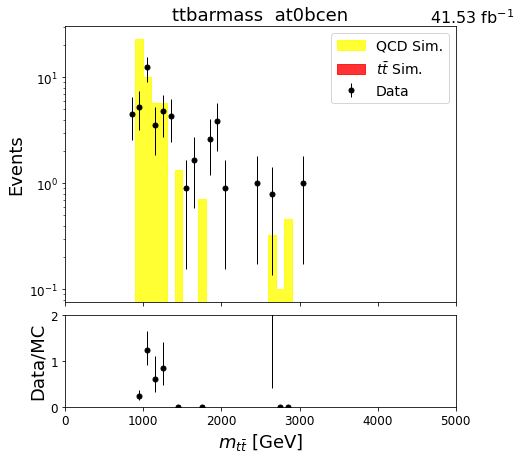

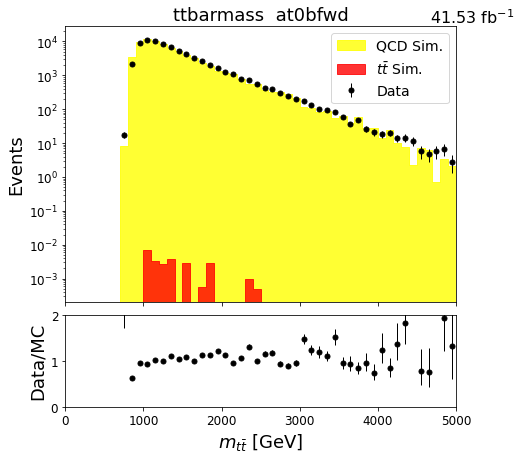

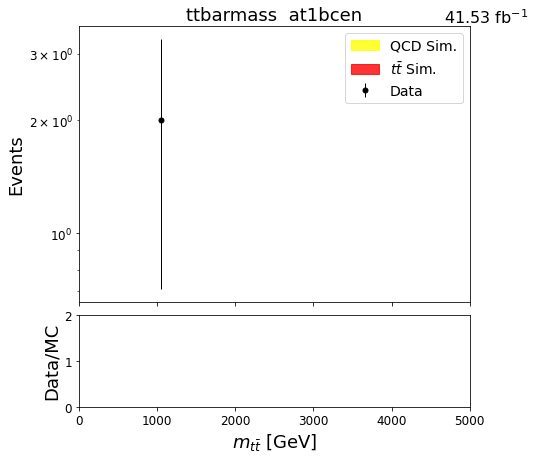

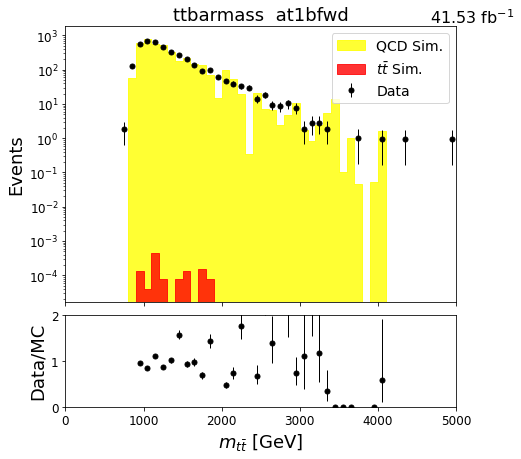

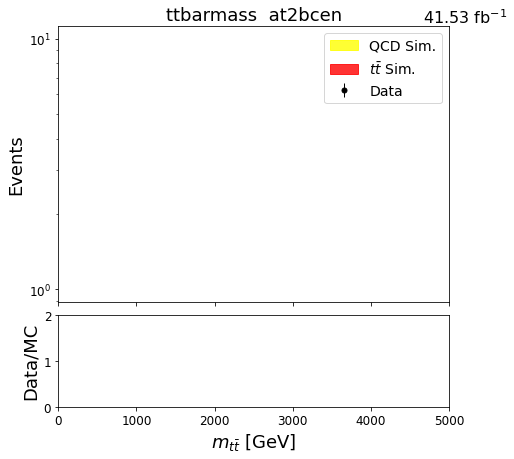

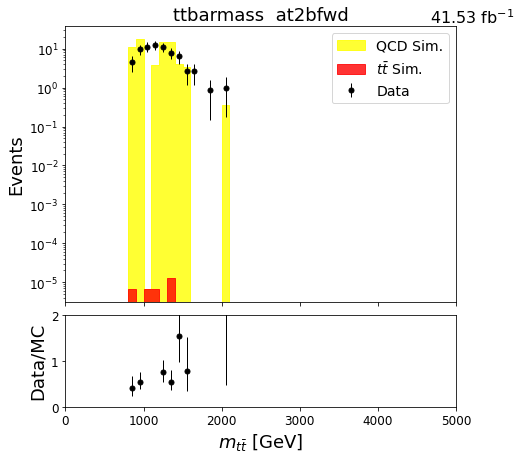

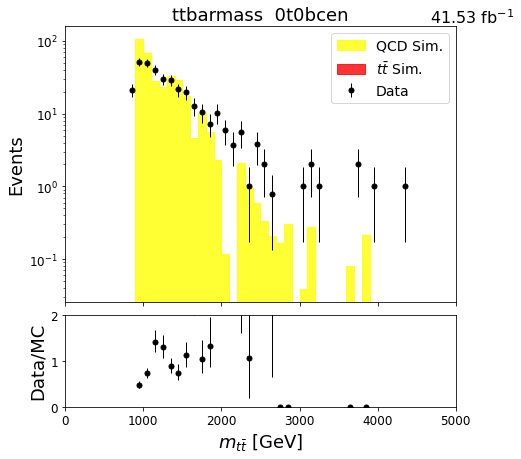

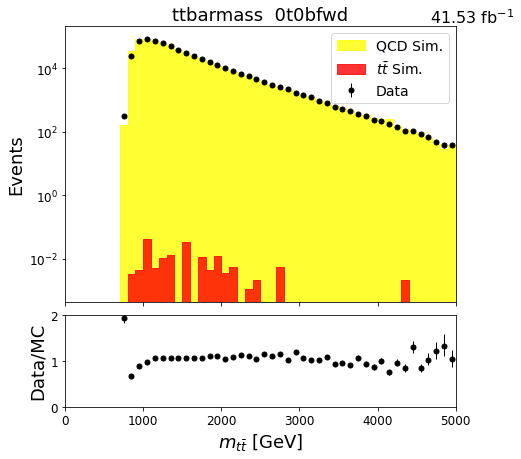

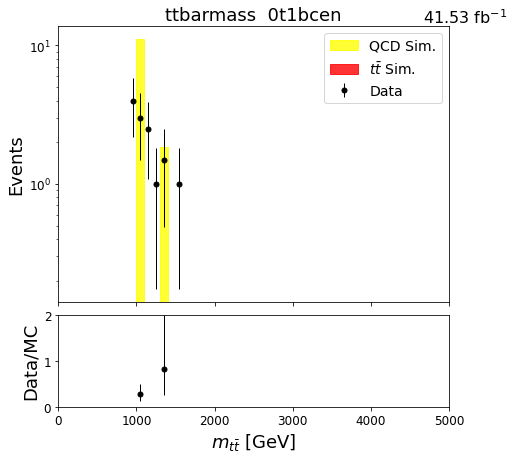

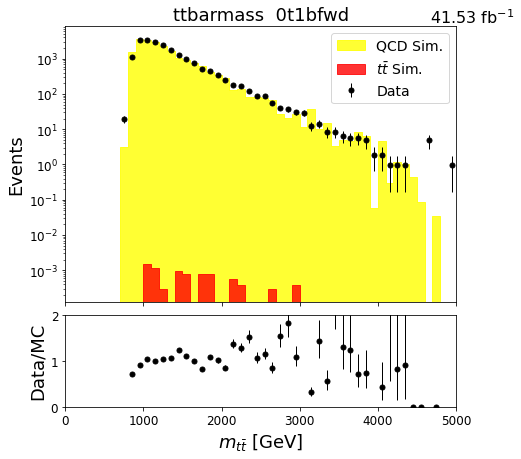

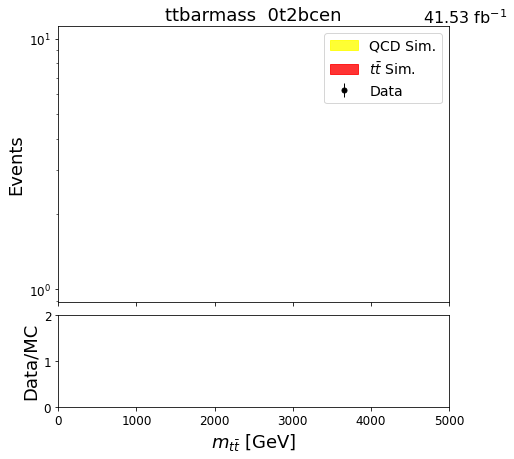

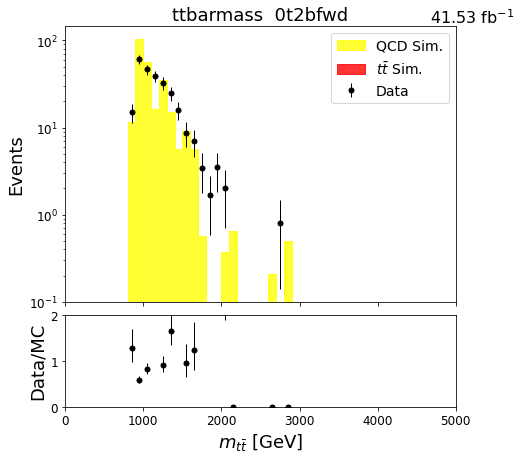

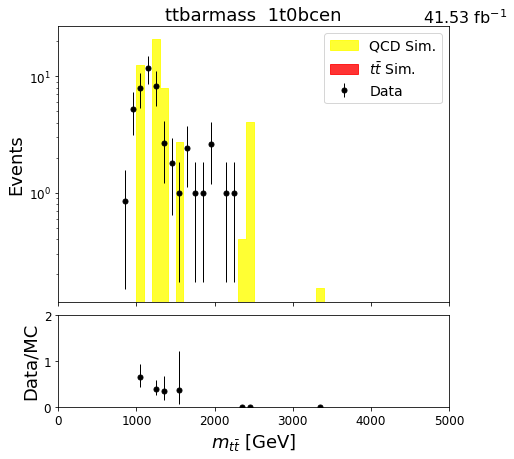

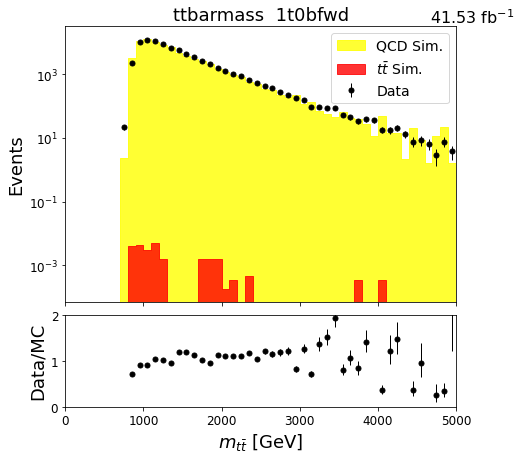

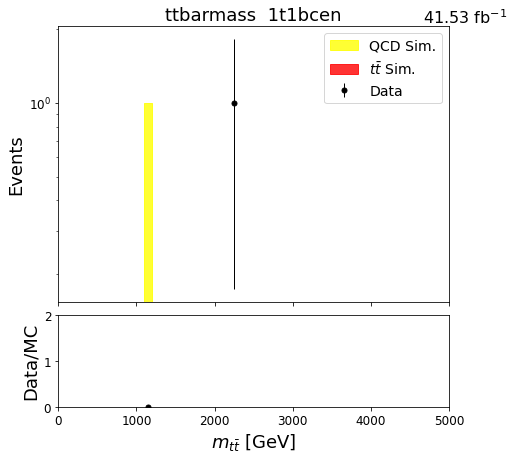

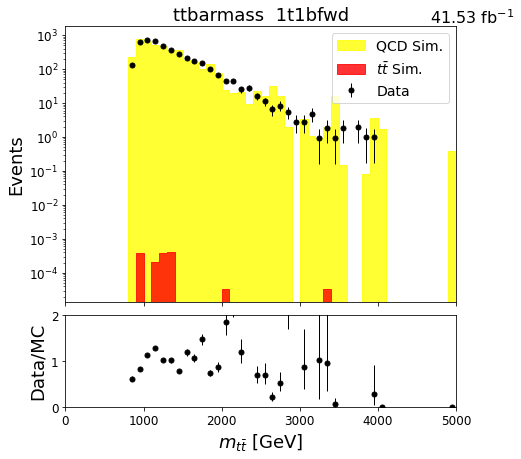

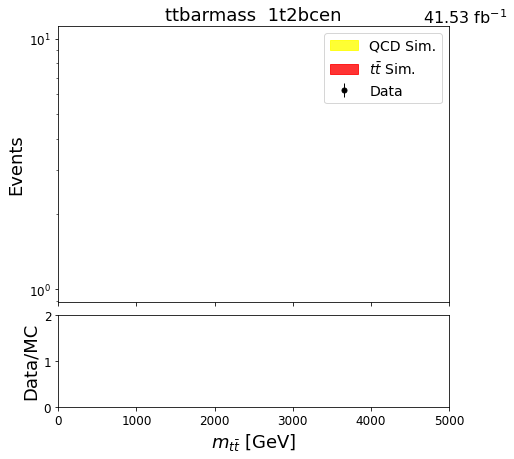

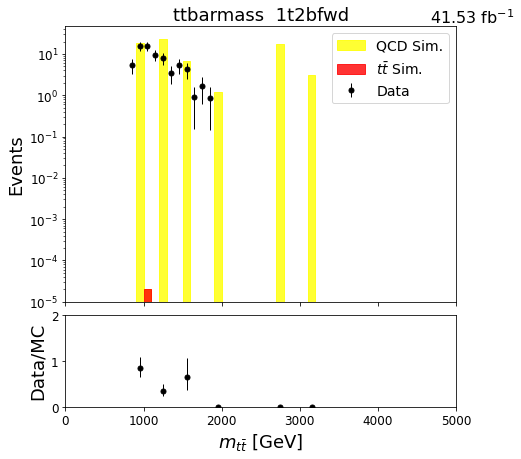

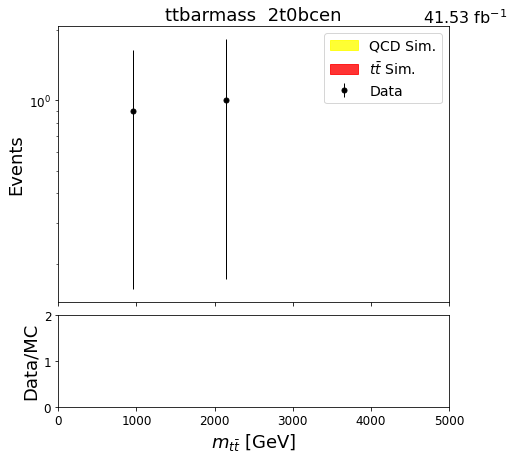

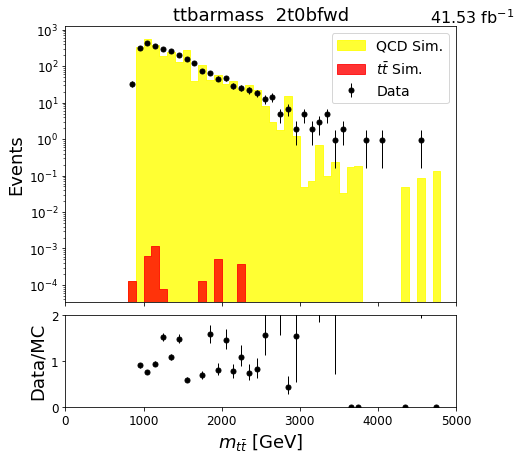

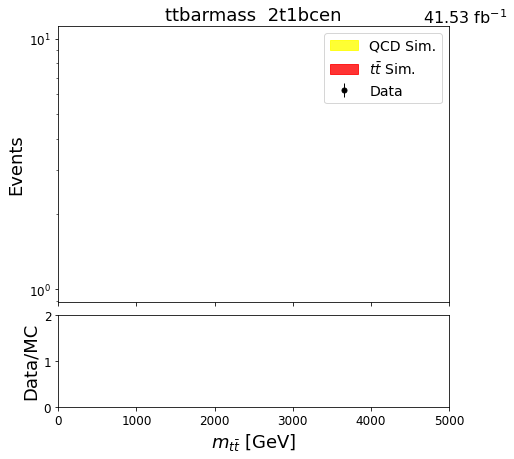

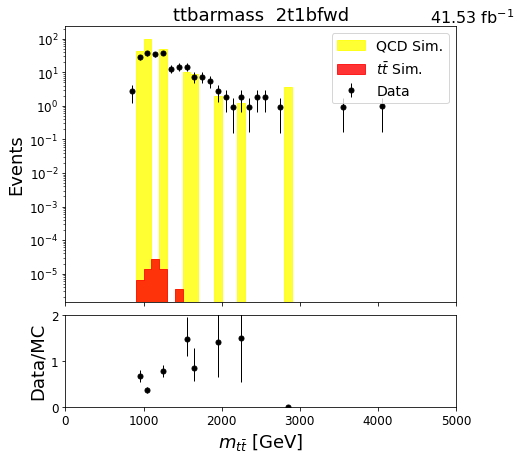

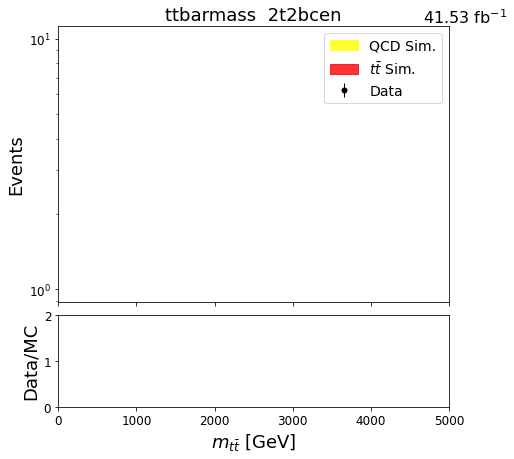

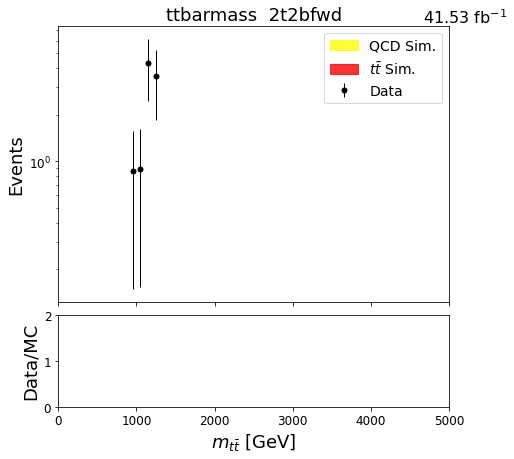

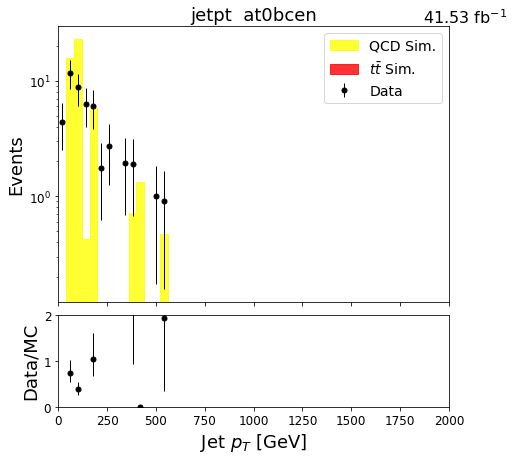

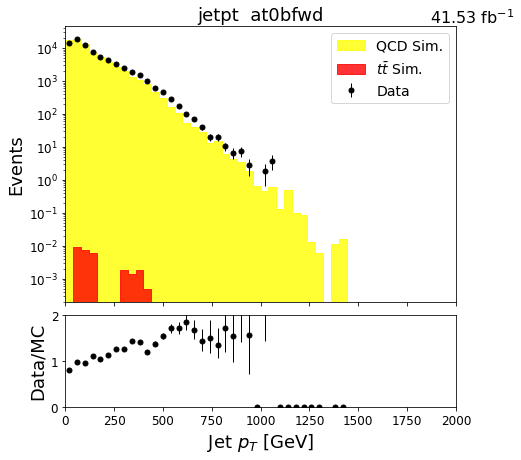

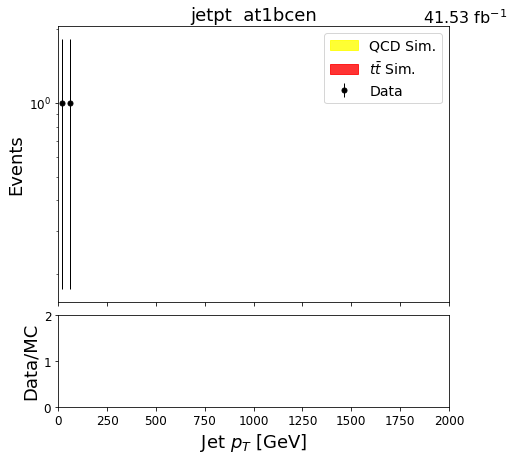

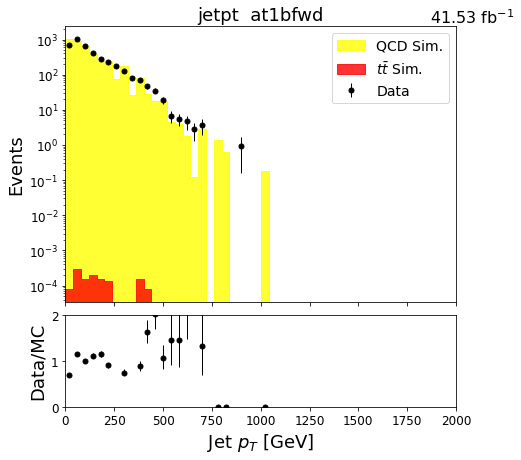

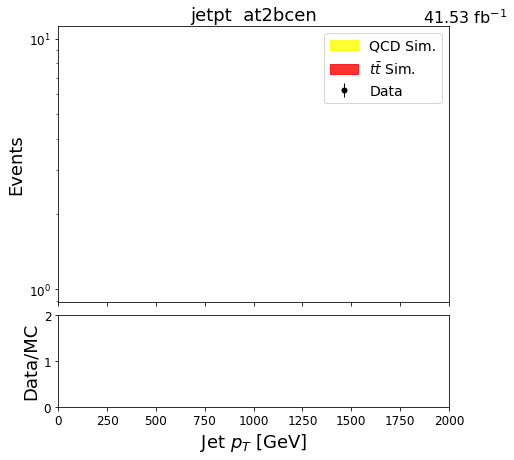

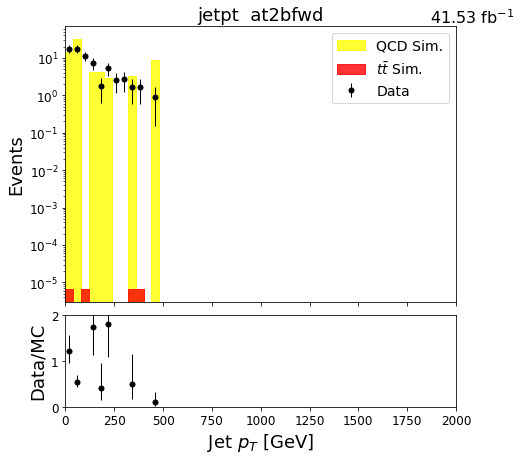

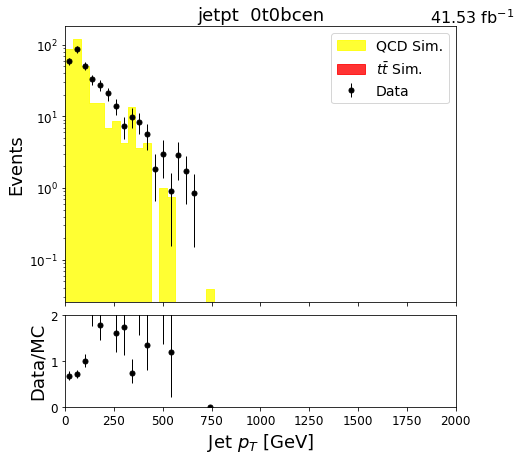

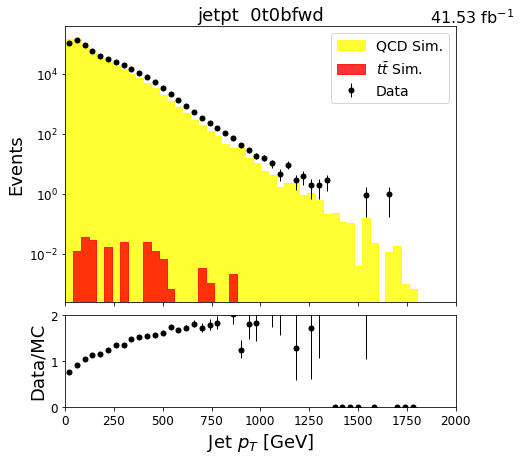

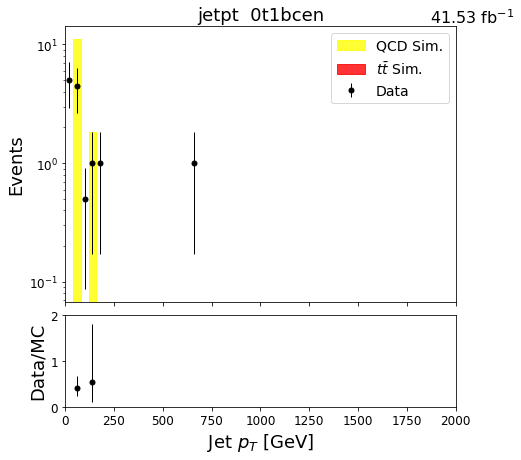

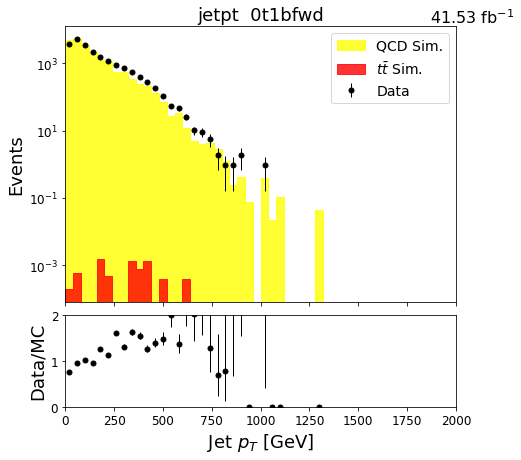

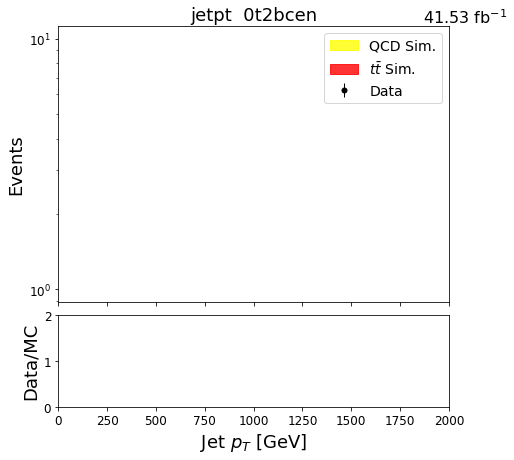

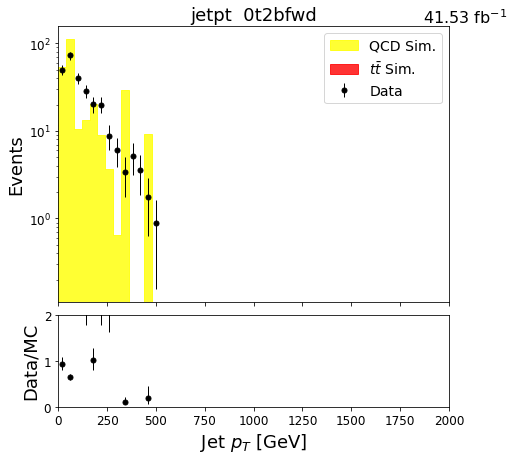

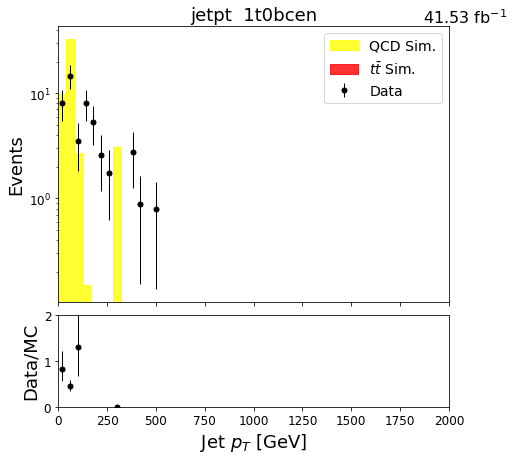

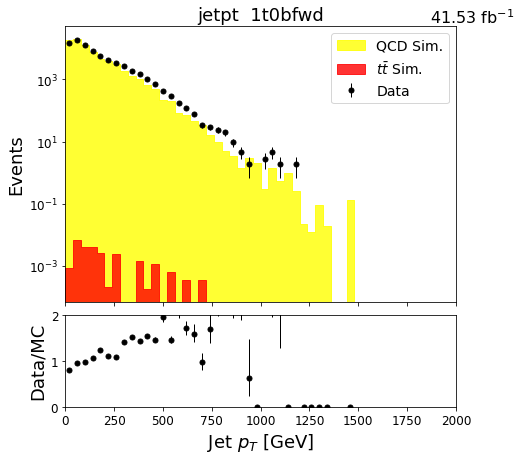

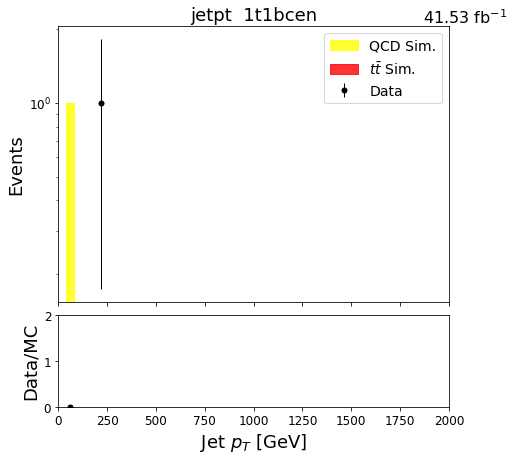

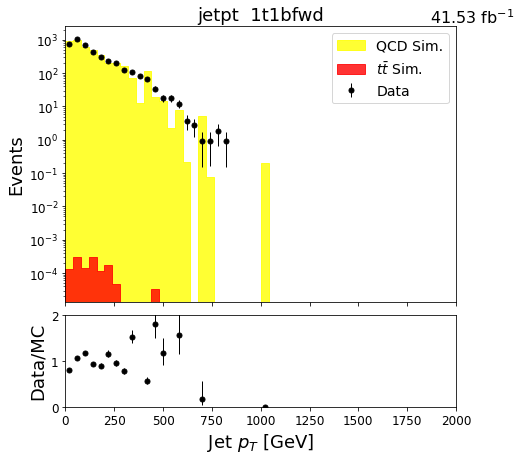

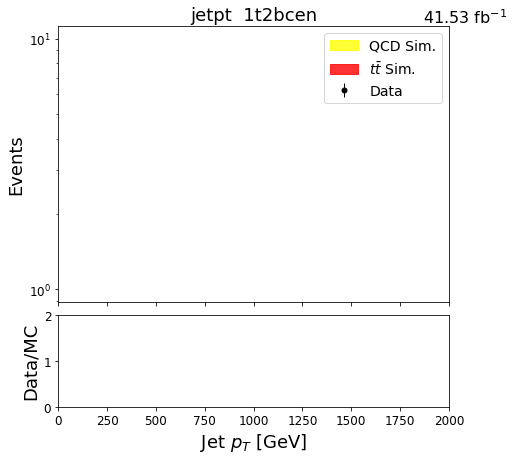

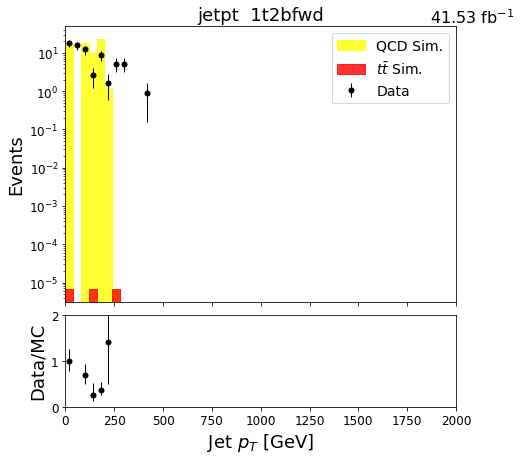

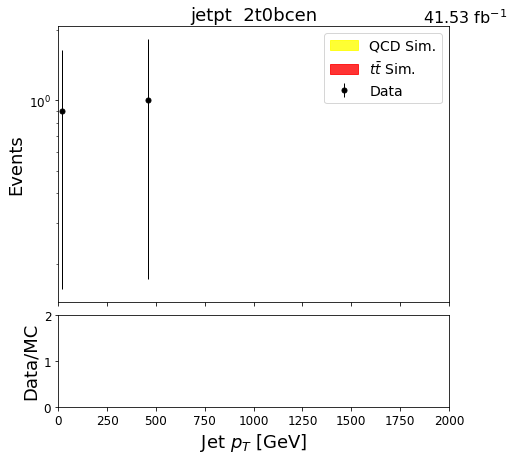

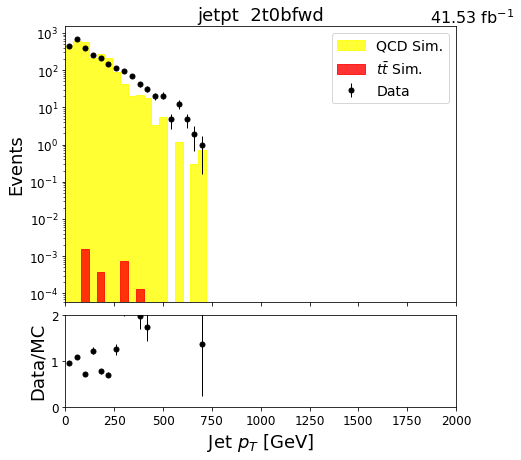

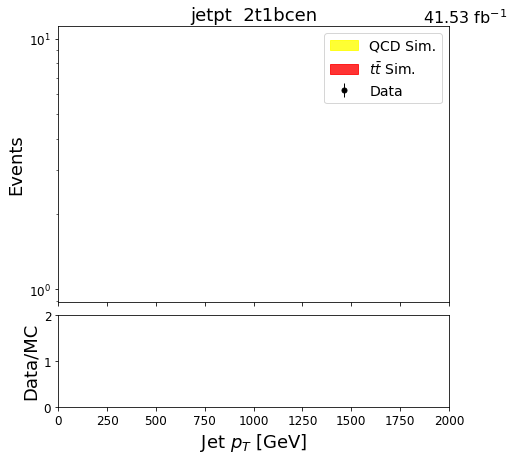

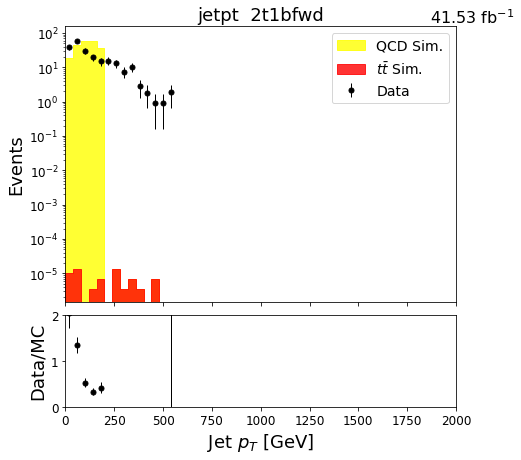

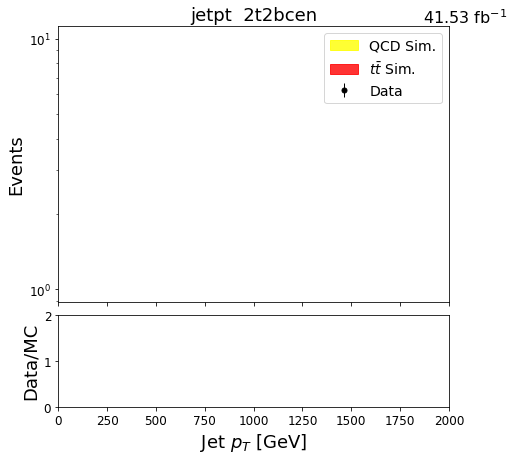

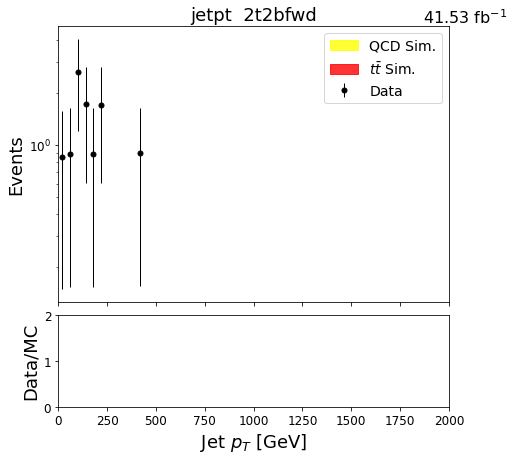

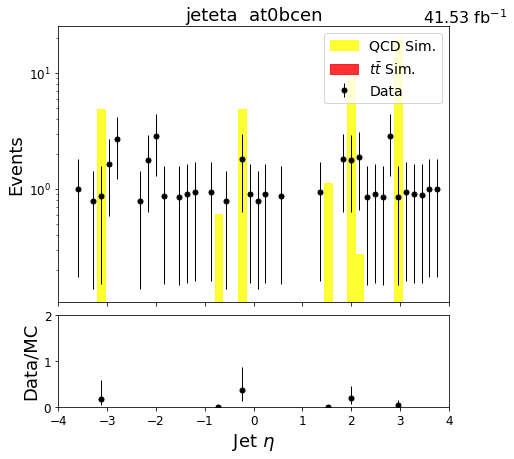

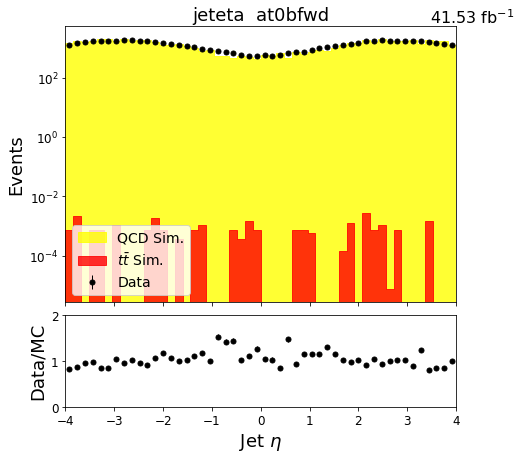

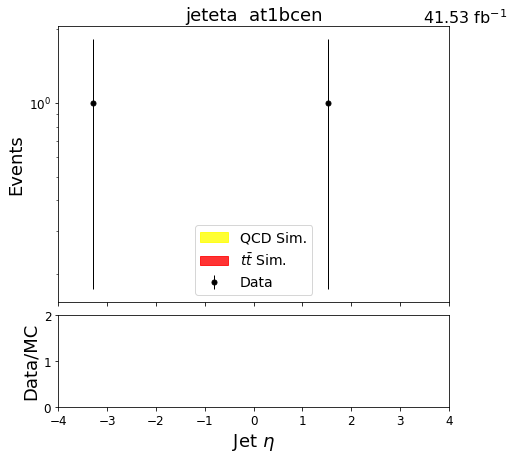

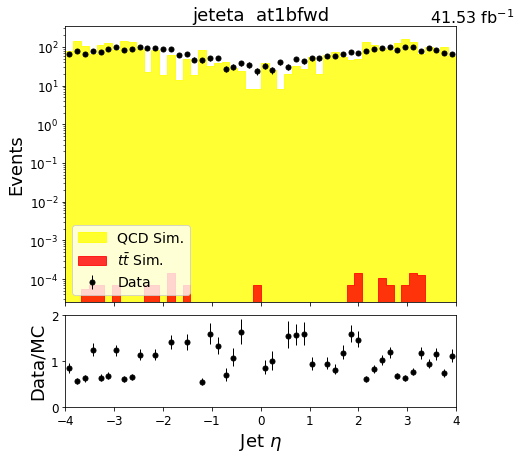

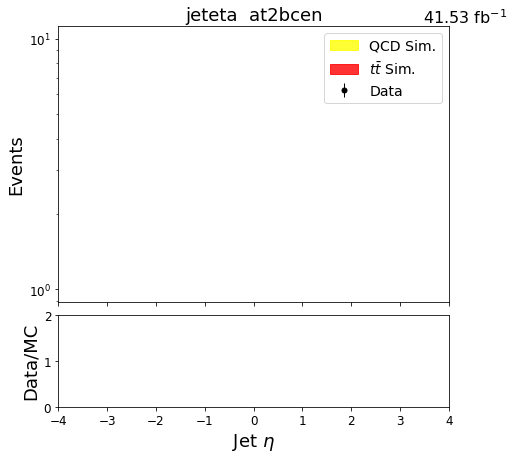

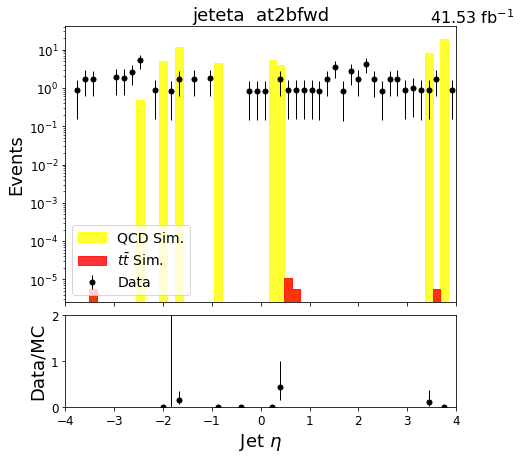

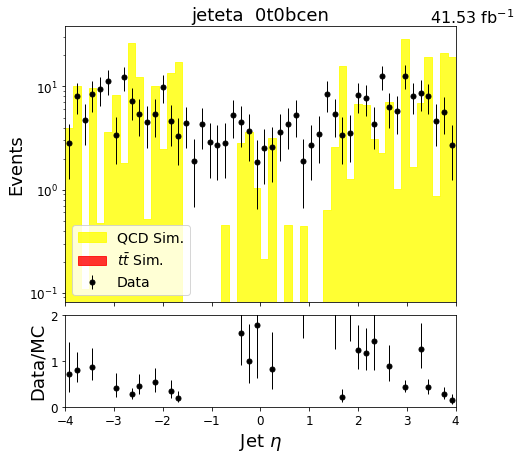

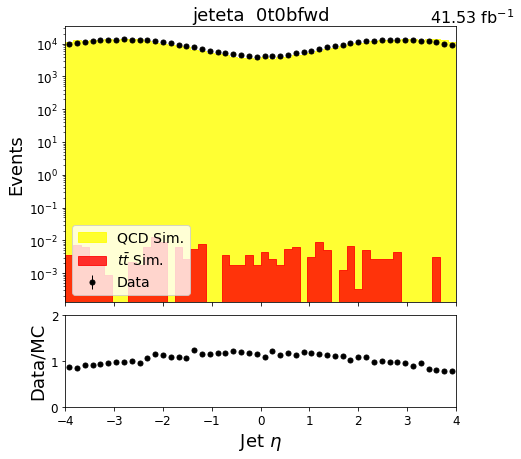

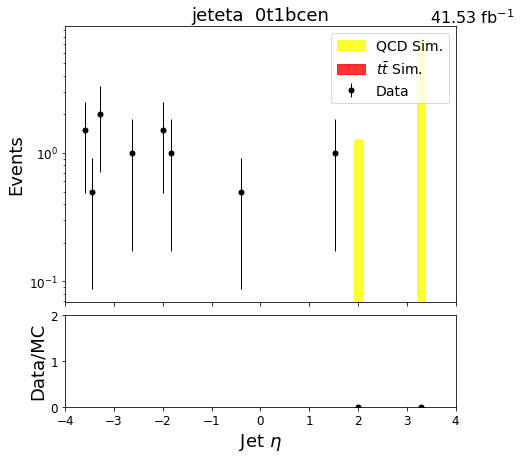

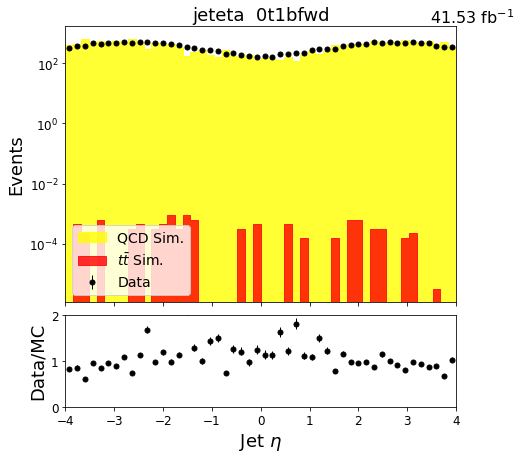

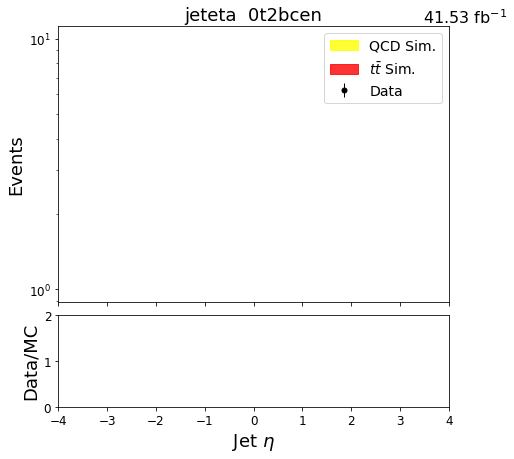

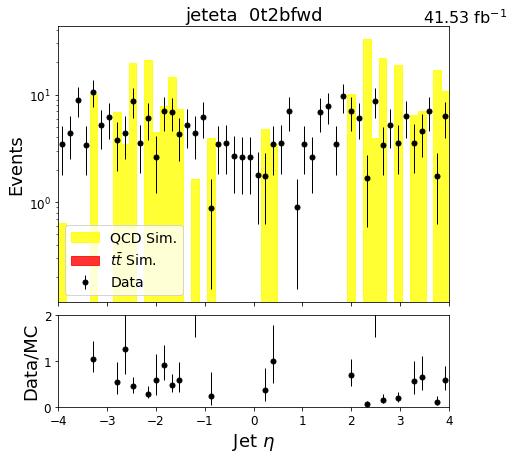

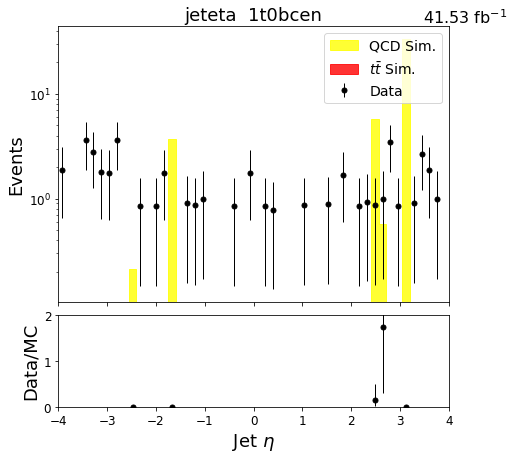

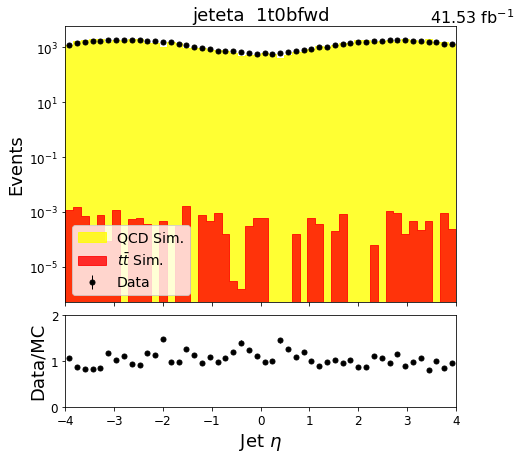

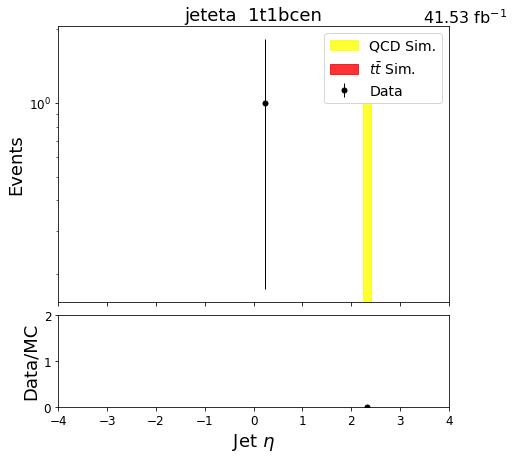

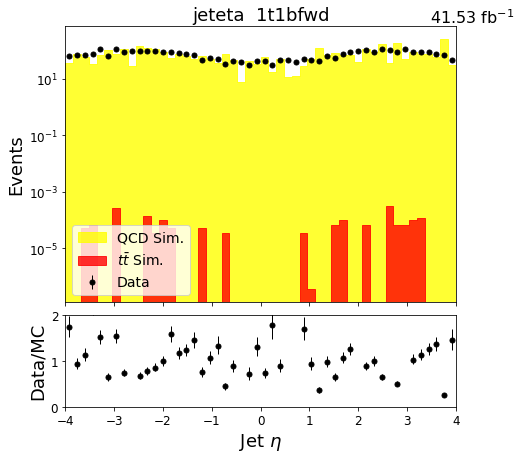

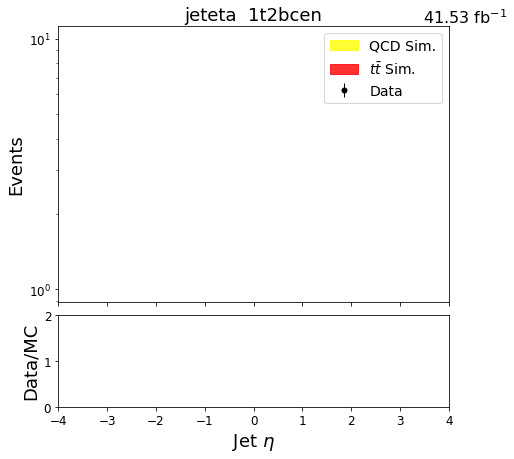

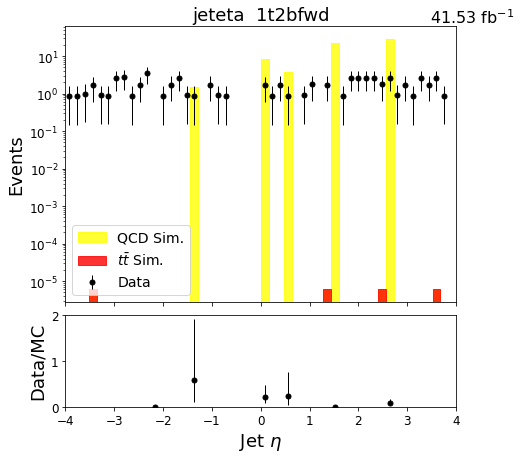

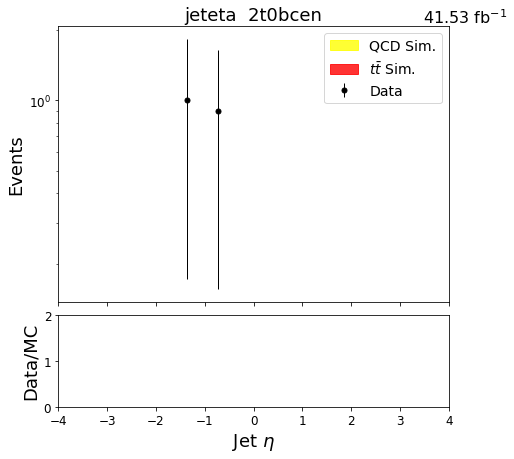

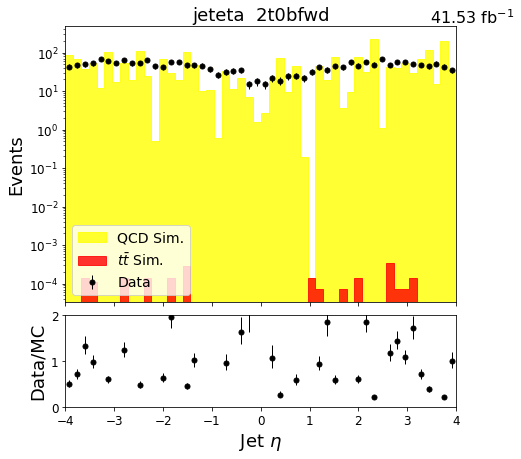

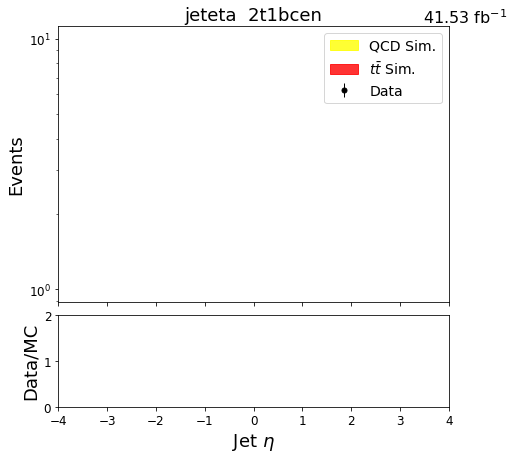

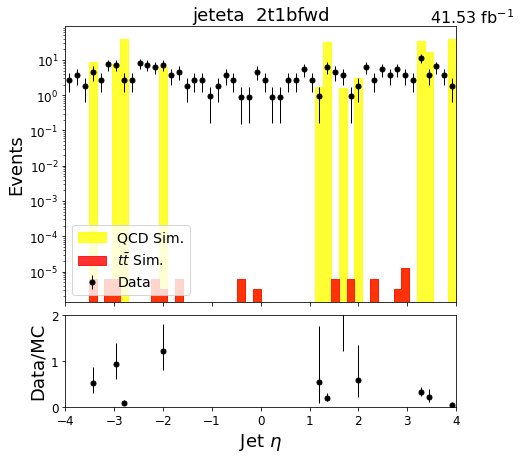

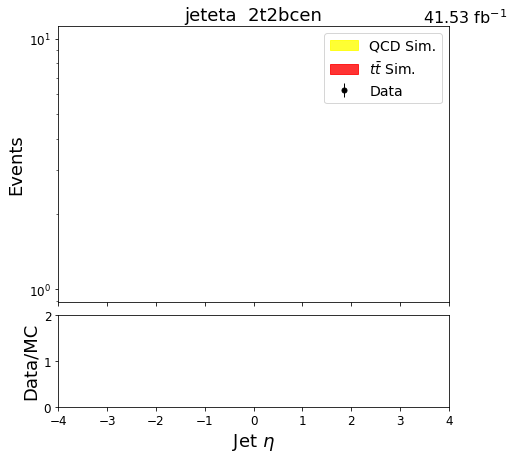

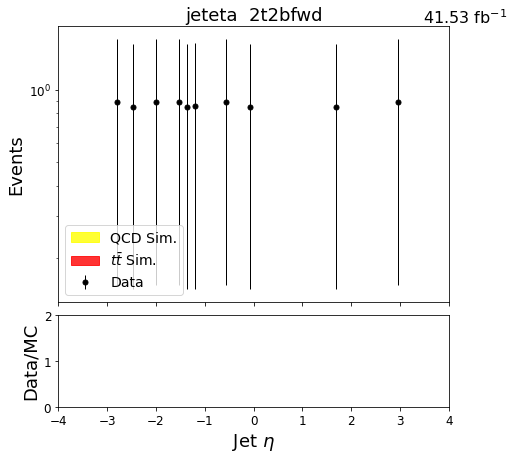

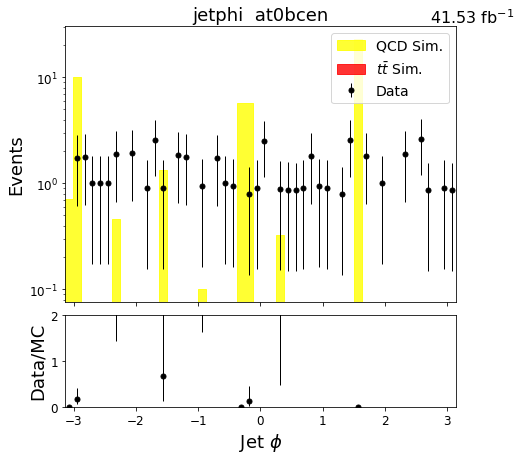

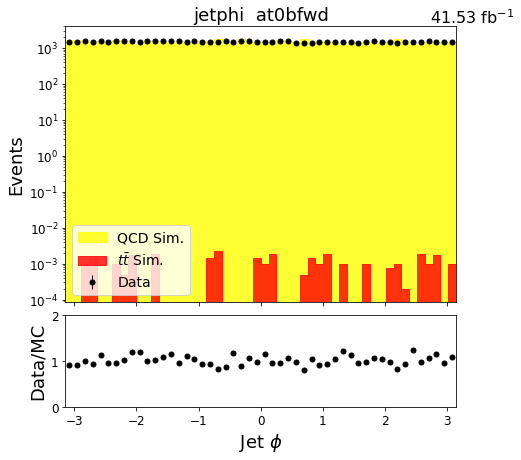

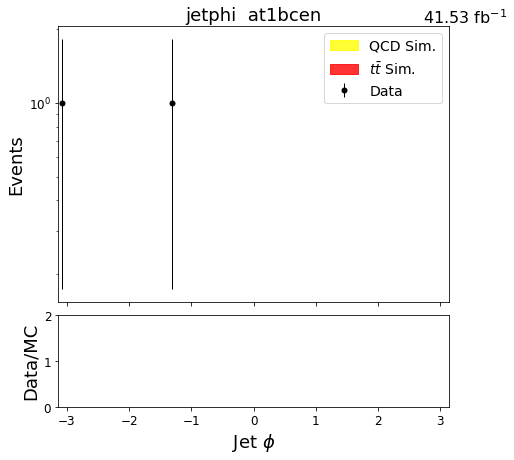

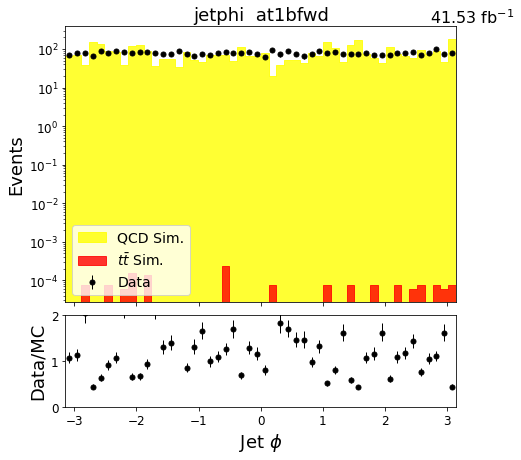

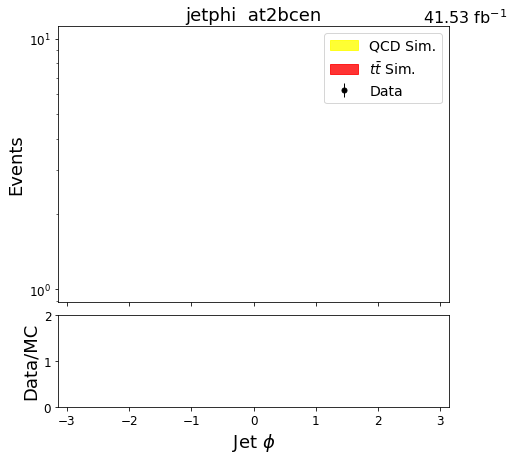

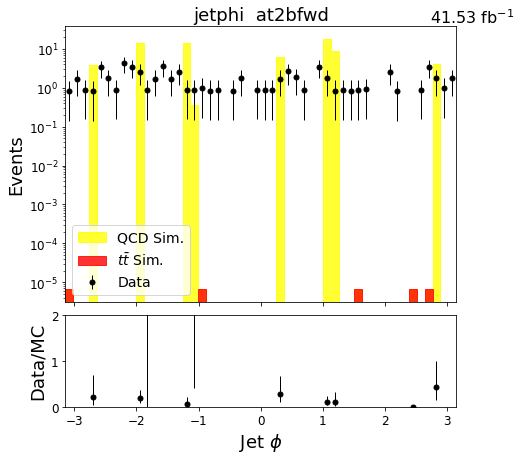

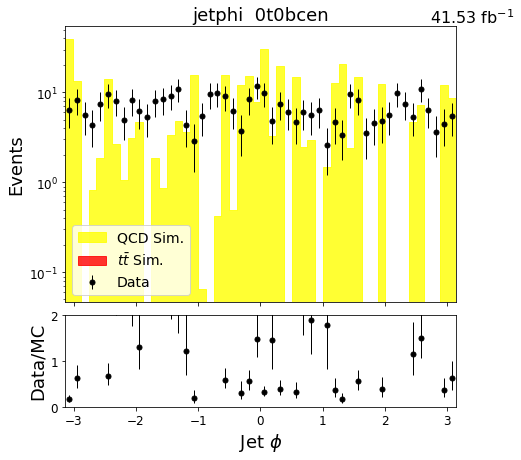

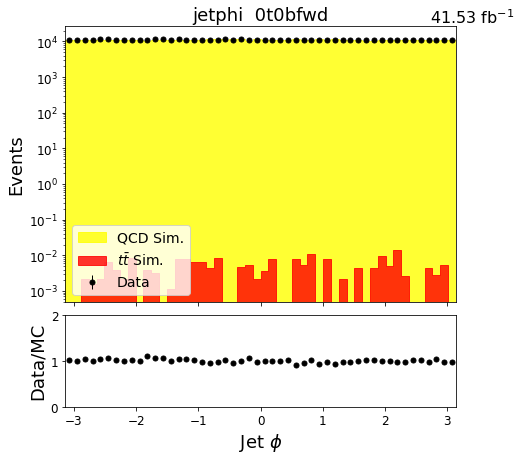

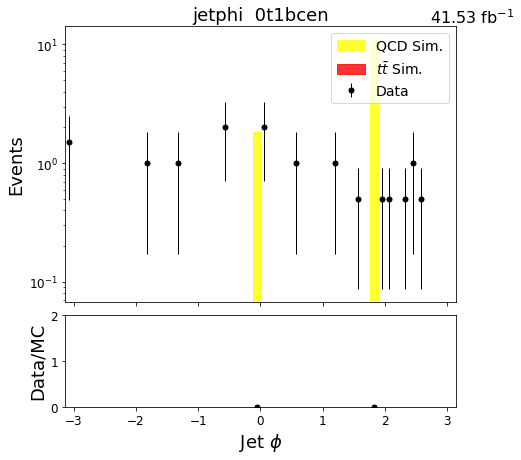

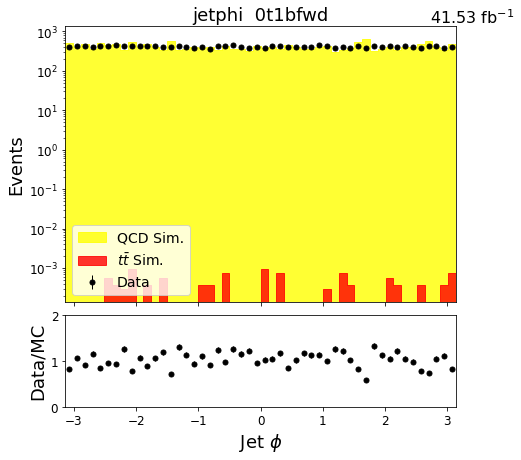

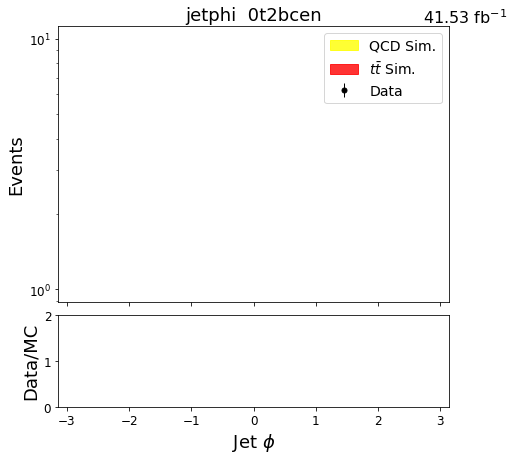

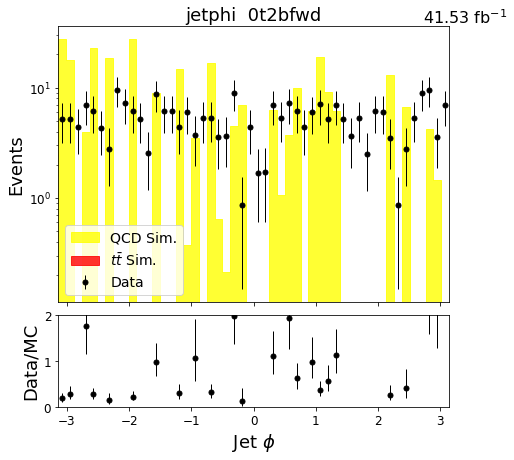

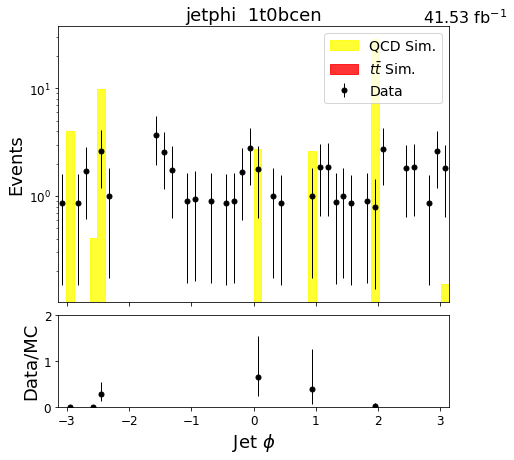

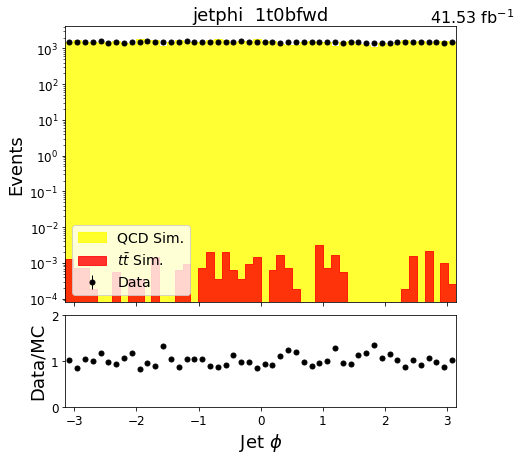

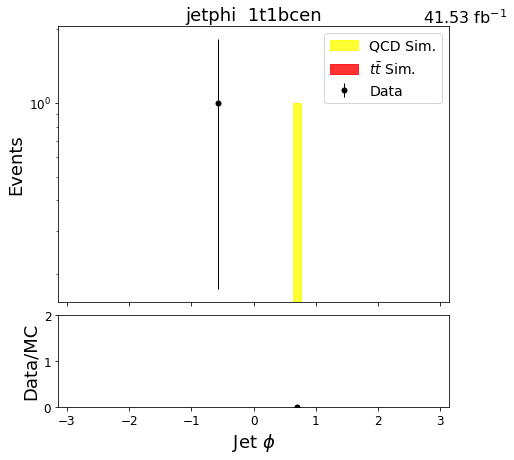

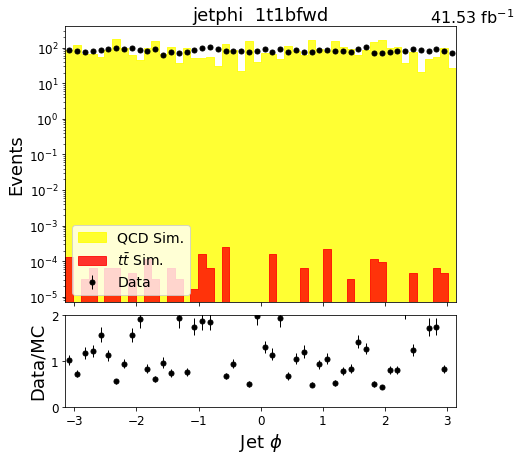

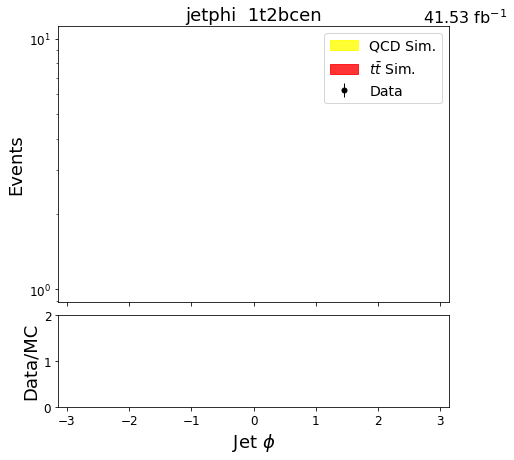

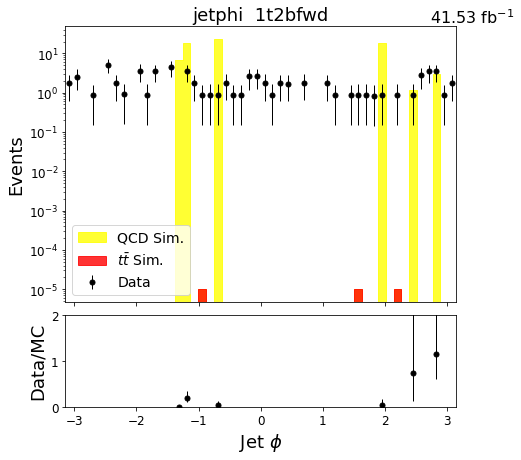

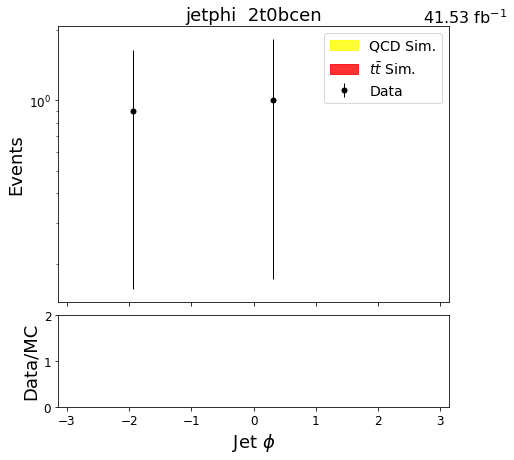

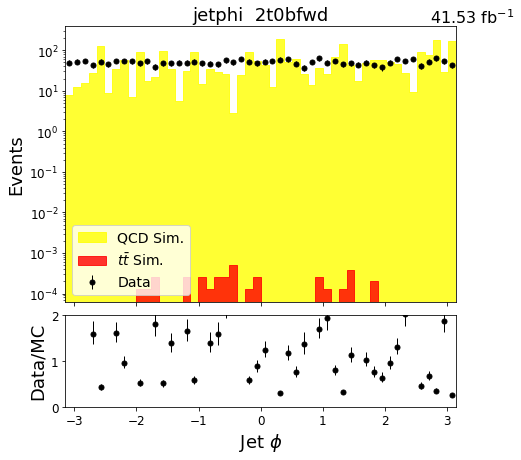

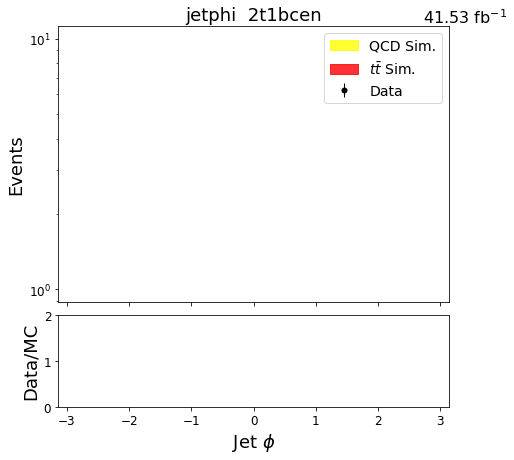

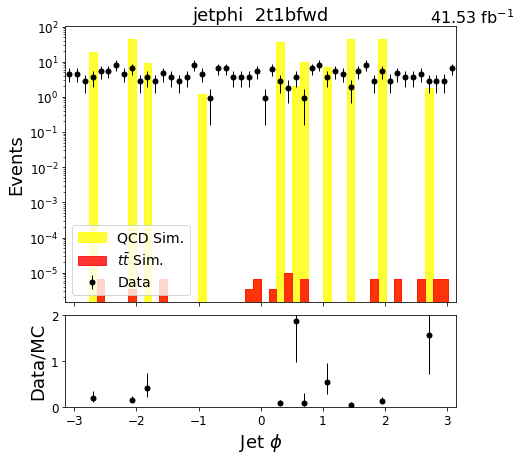

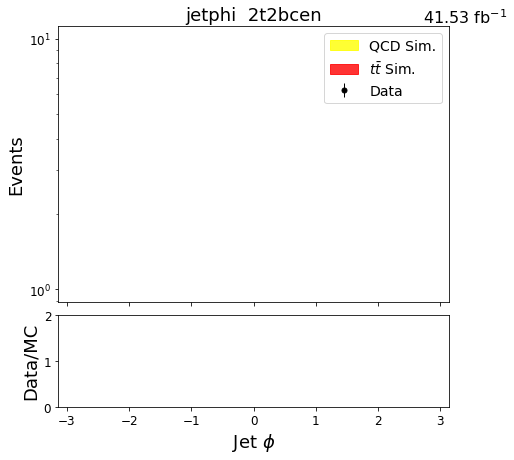

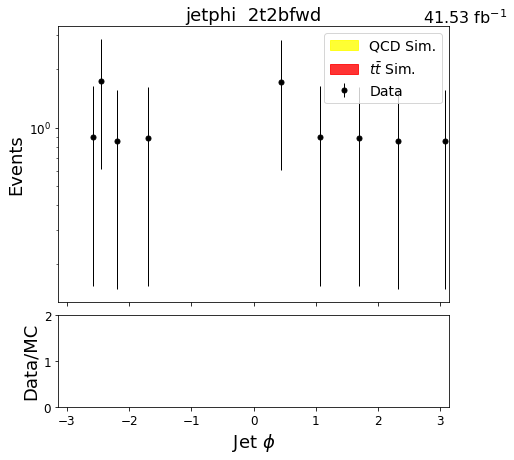

In [16]:
""" ---------------- Data and Total MC Plots ---------------- """

for ihist in list_of_hists:
    SaveDirectory = maindirectory + '/' + ihist + '/' # split histograms into subdirectories
    DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already
    for icat in list_of_cats: 
        plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 18,
        'axes.labelsize': 18,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
        })
        fig, (ax, rax) = plt.subplots(
            nrows=2,
            ncols=1,
            figsize=(7,7),
            gridspec_kw={"height_ratios": (3, 1)},
            sharex=True
        )
        fig.subplots_adjust(hspace=.07)
        title = ihist + '  ' + icat
        filename = ihist + '_' + icat + '.' + 'png'
        
        #---- Define Histograms by category and scale the Total----# 
        
        # ---- Start with TTbar MC ---- #
        TTbar_hist = output[ihist].integrate('anacat', icat).integrate('dataset', 'TTbar')
        MC_hist = TTbar_hist.copy() # starting histogram
        Ntt = np.sum(MC_hist.integrate(ihist).values()) # extract number of events from histogram directly
        Ntt = [i for i in Ntt.values()] # the zeroth column entry is the number of events defined as a float
        if Ntt[0] > 0.:
            MC_hist.scale(ttbar_xs/Ntt[0]) # Normalized to ttbar xs
        else:
            MC_hist.scale(0.)
        
        # ---- Repeat above procedure for QCD and add QCD cross section histogram to ttbar xs histogram ---- #
        QCD_hist = output[ihist].integrate('anacat', icat).integrate('dataset', 'QCD')
        Nqcd = np.sum(QCD_hist.integrate(ihist).values())
        Nqcd = [j for j in Nqcd.values()]
        if Nqcd[0] > 0.:
            QCD_hist.scale(qcd_xs/Nqcd[0]) # Normalized to qcd xs
        else:
            QCD_hist.scale(0.)
            
        MC_hist.add(QCD_hist) # Add Normalized MC Histograms to get Total MC
        
        # ---- Define the data histogram ---- #
        Data_hist = output[ihist].integrate('anacat', icat).integrate('dataset', 'JetHT')
        
        # ---- Extract data events and total cross section from histograms ---- #
        NtotalMC = np.sum(MC_hist.integrate(ihist).values())
        NtotalMC = [k for k in NtotalMC.values()]
        
        NtotalData = np.sum(Data_hist.integrate(ihist).values())
        NtotalData = [l for l in NtotalData.values()]
        
        # ---- Normalize the total cross section histogram to the data ---- #
        if NtotalMC[0] > 0.:
            MC_hist.scale(NtotalData[0]/NtotalMC[0])
        else:
            MC_hist.scale(0.)
            
        NtotalMC_scaled = np.sum(MC_hist.integrate(ihist).values())
        print('QCD ' + filename + ' ', NtotalMC_scaled)
        
        #---- Plot Total MC ----#
        #-----------------------------------------------------------------#
        hist.plot1d(MC_hist, ax=ax, clear=False,
                    fill_opts=stack_background_opts, error_opts=stack_error_opts)
        
        if Ntt[0] > 0:
            TTbar_hist.scale((NtotalData[0]/NtotalMC[0])*(ttbar_xs/Ntt[0]))
        else:
            TTbar_hist.scale(0.)
        NTTbar_scaled = np.sum(TTbar_hist.integrate(ihist).values())
        print('TTbar' + filename + ' ', NTTbar_scaled)
            
        #---- Plot TTbar MC ---- #
        #-----------------------------------------------------------------#
        hist.plot1d(TTbar_hist, ax=ax, clear=False,
                    fill_opts=stack_ttbar_opts, error_opts=stack_error_opts)
        
        print('Data' + filename + ' ', NtotalData)
        #---- Plot Data ----#
        #-----------------------------------------------------------------#
        hist.plot1d(Data_hist, ax=ax, clear=False, 
                    error_opts=data_err_opts)
        
        ax.set_yscale('log')
        ax.autoscale('y')
        ax.autoscale('x')#, tight=True) # doesn't look like its working...
        ax.set_ylabel('Events')
        ax.set_xlabel(None)
        ax.set_title(title)
        leg = ax.legend(labels=["QCD Sim.", r'$t\bar{t}$ Sim.', 'Data'])
        
        #---- Plot Ratio ----#
        hist.plotratio(num = Data_hist, denom = MC_hist, ax = rax,
                       error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                       unc = 'num')
        rax.set_ylabel('Data/MC')
        rax.set_ylim(0,2)
       
        #---- Labeling ----#
        Lint = str(Lum*.001) # Integrated Luminosity
        lumi = plt.text(1.15, 1.07, Lint[:6] + " fb$^{-1}$",
                fontsize=16,
                horizontalalignment='right',
                verticalalignment='top',
                transform=ax.transAxes
               )
        #plt.savefig(SaveDirectory+filename, bbox_inches="tight")
        #print(filename + ' saved')
        print()
    

In [ ]:
""" ---------------- SCALES PLOTS ACCORDING TO LUMINOSITY AND INFO IN THE PREVIOUS TWO CELLS ---------------- """
"""
notdata = re.compile('(?!JetHT)')  

for ihist in list_of_hists:
    SaveDirectory = maindirectory + '/' + ihist + '/' # split histograms into subdirectories
    DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already
    for icat in list_of_cats: 
        plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 18,
        'axes.labelsize': 18,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
        })
        fig, (ax, rax) = plt.subplots(
            nrows=2,
            ncols=1,
            figsize=(7,7),#TTbar_sf = Ratio
#QCD_sf = Ratio
            gridspec_kw={"height_ratios": (3, 1)},
            sharex=True
        )
        fig.subplots_adjust(hspace=.07)
        title = ihist + '  ' + icat
        filename = ihist + '_' + icat + '.' + 'png'
        
        #---- Define Histogram by category and scale each histogram----# 
        histogram = output[ihist].integrate('anacat', icat)
        histogram.scale(scales, 'dataset') 
        
        #---- Plot MC ----#
        hist.plot1d(histogram[notdata], ax=ax, clear=False, overlay='dataset', stack=False, # stack not working
                    fill_opts=stack_fill_opts, error_opts=stack_error_opts)
        #---- Plot Data ----#
        hist.plot1d(histogram['JetHT'], ax=ax, clear=False, error_opts=data_err_opts)
        #if ihist != 'jeteta':
        ax.set_yscale('log')
        #else:
        #    pass
        ax.autoscale('y')
        ax.autoscale('x')#, tight=True) # doesn't look like its working...
        ax.set_ylabel('Events')
        ax.set_xlabel(None)
        ax.set_title(title)
        leg = ax.legend()
        
        #---- Plot Ratio ----#
        hist.plotratio(num = histogram['JetHT'].sum('dataset'), denom = histogram[notdata].sum('dataset'), ax = rax,
                       error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                       unc = 'num')
        rax.set_ylabel('Data/MC')
        rax.set_ylim(0,2)
       
        #---- Labeling ----#
        Lint = str(Lum_frac*.001) # Integrated Luminosity
        lumi = plt.text(1.15, 1.07, Lint[:6] + " fb$^{-1}$",
                fontsize=16,
                horizontalalignment='right',
                verticalalignment='top',
                transform=ax.transAxes
               )
        #plt.savefig(SaveDirectory+filename, bbox_inches="tight")
        #print(filename + ' saved')
"""